In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

### 载入模型
使用pytorch自带VGG19模型，预训练好的模型存放在路径 ~/.torch/models/vgg19-dcbb9e9d.pth

In [2]:
vgg = models.vgg19(pretrained=True)
vgg.cuda()
# 打印出VGG19模型的结构
print(vgg.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

#### 载入图像
使用了文章中提到的风格图像--梵高的星夜图、内容图像--德国Tuebingen小镇的照片

(1920, 1080)
(1024, 768)


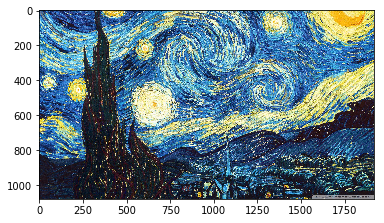

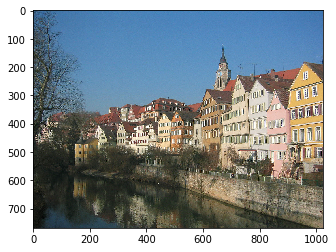

In [3]:
style_image = Image.open('starry_night2.jpg')
print(style_image.size)
content_image = Image.open('Tuebingen_Neckarfront.jpg')
print(content_image.size)
plt.imshow(style_image)
plt.show()
plt.imshow(content_image)
plt.show()

#### 数据预处理
1. 为了适应Imagenet预训练好的模型，对输入图像进行训练时相同的预处理

2. 同时，为了输出正常的图像，需要对结果进行反变换，并且将结果图clip到合适的范围内

In [4]:
# 根据官方提供的预训练得到的VGG模型对图像进行预处理
preprocess = transforms.Compose(
    [
        transforms.Resize(500),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
# 反变换成图片
inv_preprocess = transforms.Compose(
    [
        transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
        transforms.Lambda(lambda x: (x-x.min()) / (x.max()-x.min())),
        transforms.ToPILImage(),
    ])

### 隐含层的选择和激活值的提取
1. 根据文章中的实验，我们使用VGG19中的**conv_42**作为生成图像content的标准  
2. 使用**conv_11、conv_21、conv_31、conv_41、conv_51**作为生成图像style的标准  
3. 同时为了不破坏pytorch提供的预训练好的VGG模型的结构，我是用了pytorch中的**hook函数**来进行隐含层feature map的提取

In [5]:
# 指定content从哪层提取
content_layers = {'c42':22}
style_layers = {'c11':1,'c21':6,'c31':11,'c41':20,'c51':29} 

# 保存在list中
content_feature = []
style_feature = []

# 定义hook函数
def content_hook(self, input, output):
#     print('content feature shape: ', output.shape)
    content_feature.append(output.clone()) 

def style_hook(self, input, output):
#     print('style feature shape: ', output.shape)
    style_feature.append(output.clone())
    
# 为指定层添加hook
content_handle = [vgg.features[i].register_forward_hook(content_hook) for i in content_layers.values()]
style_handle = [vgg.features[i].register_forward_hook(style_hook) for i in style_layers.values()]

# 提取一张图的目标content
content_feature.clear()
style_feature.clear()
content_tensor = preprocess(content_image)
content_tensor = content_tensor.unsqueeze(0).cuda()
print(content_tensor.shape)
_ = vgg.features.forward(content_tensor)
content_targets = [f.detach() for f in content_feature]
print([f.shape for f in content_targets])

# 提取另一张图的目标style
content_feature.clear()
style_feature.clear()
style_tensor = preprocess(style_image)
style_tensor = style_tensor.unsqueeze(0).cuda()
print(style_tensor.shape)
_ = vgg.features.forward(style_tensor)
style_targets = [f.detach() for f in style_feature]
print([f.shape for f in style_targets])

torch.Size([1, 3, 500, 666])
[torch.Size([1, 512, 62, 83])]
torch.Size([1, 3, 500, 888])
[torch.Size([1, 64, 500, 888]), torch.Size([1, 128, 250, 444]), torch.Size([1, 256, 125, 222]), torch.Size([1, 512, 62, 111]), torch.Size([1, 512, 31, 55])]


### Loss function的实现
根据文章中的公式，写出计算content loss和style loss的计算代码

In [6]:
class ContentLoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(input, target)
        return(out)

class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.shape
        F = input.view(b, c, h * w)
        G = torch.bmm(F, F.transpose(1, 2))
        return G
    
gram = GramMatrix()
class StyleLoss(nn.Module):
    def forward(self, input, target):
        b, c, h, w = input.shape
        out = F.mse_loss(gram(input), gram(target), size_average=False)
        out = out / (4 * (c**2) * ((h*w)**2))
        return(out)
content_loss = ContentLoss()
style_loss = StyleLoss()

### 实验
根据文章中的说明，分别进行了两种情况的实验验证：
1. 使用原图作为输入图像；
2. 实验噪声图像作为输入图像；

In [7]:
# 设输入图像为conten的原图
opt_img = Variable(content_tensor.clone(), requires_grad=True)

# 设定损失的权重
alpha = 1.
beta = 1e3
# α/β = 1e-3
content_weights = [alpha]
style_weights = [(1./len(style_layers)) * beta for n in range(len(style_layers))]
weights = content_weights + style_weights
targets = content_targets + style_targets
loss_fns = [content_loss] * len(content_layers) + [style_loss] * len(style_layers)

In [8]:
# 对图片进行生成迭代
optimizer = optim.LBFGS([opt_img], lr=1., max_iter=300)
show_iter = 50
n_iter = 0

def closure():
    content_feature.clear()
    style_feature.clear()
    optimizer.zero_grad()
    _ = vgg.features.forward(opt_img)
    features = content_feature + style_feature
    layer_losses = [weights[i] * loss_fns[i](f, targets[i]) for i, f in enumerate(features)]
    loss = sum(layer_losses)
    loss.backward(retain_graph=True)
    global n_iter
    n_iter += 1
    if n_iter % show_iter == 0 or n_iter == 1:
        print('Iteration: %d, loss: %f' % (n_iter, loss.item()))
    return loss
optimizer.step(closure)

Iteration: 1, loss: 5065.625977
Iteration: 50, loss: 29.908813
Iteration: 100, loss: 18.351946
Iteration: 150, loss: 15.233930
Iteration: 200, loss: 13.860584
Iteration: 250, loss: 13.095622
Iteration: 300, loss: 12.616042


tensor(5065.6260, device='cuda:0')

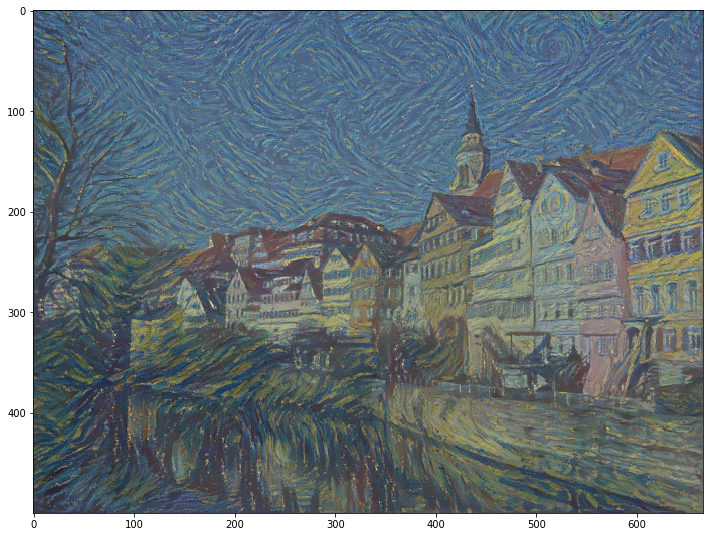

In [9]:
# 展示结果
result = inv_preprocess(opt_img.data.cpu().squeeze())
plt.figure(figsize=(12,12))
plt.imshow(result)

#### 输入为噪声图像
1. 为了防止生成的content上和原图偏差过大，首先加大对content loss的系数，得到接近原图的content表示；
2. 然后调整style loss系数，对生成图像进行style上的更改；

In [25]:
# 输入设置为噪声图像
opt_img = Variable(torch.randn(content_tensor.shape).type_as(content_tensor), requires_grad=True)
# 设定损失的权重，注重content的恢复
alpha = 1e3
beta = 1.
content_weights = [alpha]
style_weights = [(1./len(style_layers)) * beta for n in range(len(style_layers))]
weights = content_weights + style_weights
targets = content_targets + style_targets

optimizer = optim.LBFGS([opt_img], lr=1., max_iter=500)
show_iter = 50
n_iter = 0

def closure():
    content_feature.clear()
    style_feature.clear()
    optimizer.zero_grad()
    _ = vgg.features.forward(opt_img)
    features = content_feature + style_feature
    layer_losses = [weights[i] * loss_fns[i](f, targets[i]) for i, f in enumerate(features)]
    loss = sum(layer_losses)
    loss.backward(retain_graph=True)
    global n_iter
    n_iter += 1
    if n_iter % show_iter == 0 or n_iter == 1:
        print('Iteration: %d, loss: %f' % (n_iter, loss.item()))
    return loss
optimizer.step(closure)

Iteration: 1, loss: 12146.045898
Iteration: 50, loss: 1053.955688
Iteration: 100, loss: 430.764252
Iteration: 150, loss: 257.910736
Iteration: 200, loss: 181.171021
Iteration: 250, loss: 138.509781
Iteration: 300, loss: 111.588799
Iteration: 350, loss: 93.152184
Iteration: 400, loss: 80.240303
Iteration: 450, loss: 70.626076
Iteration: 500, loss: 63.286678


tensor(12146.0459, device='cuda:0')

In [26]:
# 重新设定损失的权重，注重style loss
alpha = 1.
beta = 1e3
content_weights = [alpha]
style_weights = [(1./len(style_layers)) * beta for n in range(len(style_layers))]
weights = content_weights + style_weights
targets = content_targets + style_targets


optimizer = optim.LBFGS([opt_img], lr=1., max_iter=500)
show_iter = 50
n_iter = 0

def closure():
    content_feature.clear()
    style_feature.clear()
    optimizer.zero_grad()
    _ = vgg.features.forward(opt_img)
    features = content_feature + style_feature
    layer_losses = [weights[i] * loss_fns[i](f, targets[i]) for i, f in enumerate(features)]
    loss = sum(layer_losses)
    loss.backward(retain_graph=True)
    global n_iter
    n_iter += 1
    if n_iter % show_iter == 0 or n_iter == 1:
        print('Iteration: %d, loss: %f' % (n_iter, loss.item()))
    return loss
optimizer.step(closure)

Iteration: 1, loss: 5258.235352
Iteration: 50, loss: 39.715504
Iteration: 100, loss: 21.890549
Iteration: 150, loss: 17.175995
Iteration: 200, loss: 14.912586
Iteration: 250, loss: 13.701941
Iteration: 300, loss: 13.007048
Iteration: 350, loss: 12.573494
Iteration: 400, loss: 12.260345
Iteration: 450, loss: 12.026436
Iteration: 500, loss: 11.841846


tensor(5258.2354, device='cuda:0')

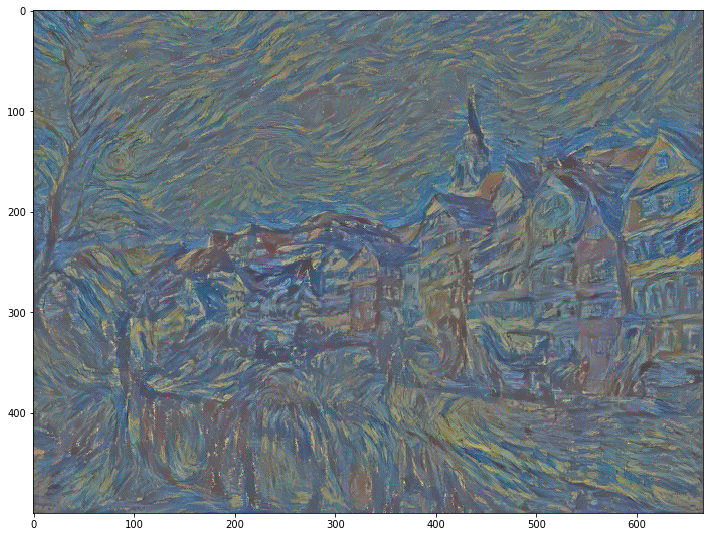

In [27]:
result = inv_preprocess(opt_img.data.cpu().squeeze())
plt.figure(figsize=(12,12))
plt.imshow(result)